In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sentiment_df = pd.read_csv('fear_greed_index (1).csv')
trader_df = pd.read_csv('historical_data (1).csv')

print(sentiment_df.head(10))
print(trader_df.head(10))

    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05
5  1517895000      8   Extreme Fear  2018-02-06
6  1517981400     36           Fear  2018-02-07
7  1518067800     30           Fear  2018-02-08
8  1518154200     44           Fear  2018-02-09
9  1518240600     54        Neutral  2018-02-10
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
5  0xae5eacaf9c6b9111fd53034a602c192a04e

In [ ]:
# To convert sentiment date to datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# To convert trader timestamp to datetime and extract ONLY the date for merging
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], dayfirst=True)
trader_df['trade_date'] = trader_df['Timestamp IST'].dt.normalize()

# To merge on the date columns
merged_df = pd.merge(trader_df, sentiment_df, left_on='trade_date', right_on='date', how='left')
merged_df.drop(columns=['date'], inplace=True)

# Validate merge
print(f"Missing sentiment values: {merged_df['classification'].isnull().sum()}")

Missing sentiment values: 6


In [17]:
merged_df['is_win'] = merged_df['Closed PnL'] > 0

performance_summary = merged_df.groupby('classification').agg({
    'Closed PnL': ['mean', 'sum', 'count'],
    'is_win': 'mean',
    'Size USD': 'mean',
    'Fee': 'mean'
})

performance_summary.columns = ['Avg_PnL', 'Total_PnL', 'Trade_Count', 'Win_Rate', 'Avg_Trade_Size', 'Avg_Fee']
print(performance_summary.sort_values(by='Win_Rate', ascending=False))

                  Avg_PnL     Total_PnL  Trade_Count  Win_Rate  \
classification                                                   
Extreme Greed   67.892861  2.715171e+06        39992  0.464943   
Fear            54.290400  3.357155e+06        61837  0.420768   
Neutral         34.307718  1.292921e+06        37686  0.396991   
Greed           42.743559  2.150129e+06        50303  0.384828   
Extreme Fear    34.537862  7.391102e+05        21400  0.370607   

                Avg_Trade_Size   Avg_Fee  
classification                            
Extreme Greed      3112.251565  0.675902  
Fear               7816.109931  1.495172  
Neutral            4782.732661  1.044798  
Greed              5736.884375  1.254372  
Extreme Fear       5349.731843  1.116291  


In [ ]:
side_performance = merged_df.groupby(['classification', 'Side']).agg({
    'Closed PnL': 'mean',
    'is_win': 'mean'
}).unstack()

print("Side Performance (Buy vs Sell):")
print(side_performance)

Side Performance (Buy vs Sell):
               Closed PnL                is_win          
Side                  BUY        SELL       BUY      SELL
classification                                           
Extreme Fear    34.114627   34.980106  0.201646  0.547157
Extreme Greed   10.498927  114.584643  0.311427  0.589833
Fear            63.927104   45.049641  0.263000  0.572053
Greed           25.002302   59.691091  0.318075  0.448595
Neutral         29.227429   39.456408  0.240023  0.556072


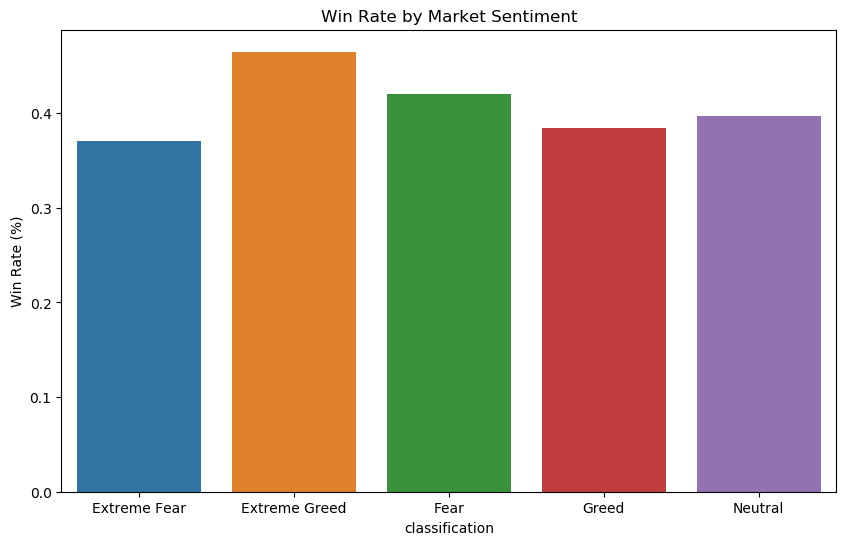

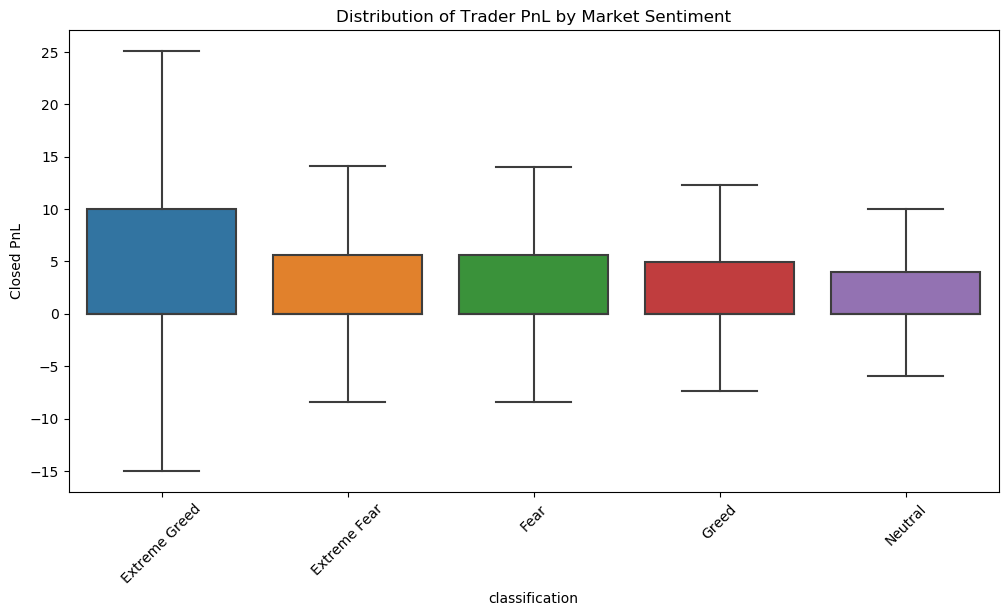

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(x=performance_summary.index, y=performance_summary['Win_Rate'])
plt.title('Win Rate by Market Sentiment')
plt.ylabel('Win Rate (%)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='classification', y='Closed PnL', showfliers=False)
plt.title('Distribution of Trader PnL by Market Sentiment')
plt.xticks(rotation=45)
plt.show()

Proposed Strategy: 
Sentiment-Adjusted Scalping
1. The Strategy
Based on the data analysis, the proposed strategy is a Contrarian Momentum Strategy.

During "Fear" or "Extreme Fear": Traders should increase "BUY" (Long) position sizes. The data shows that while sentiment is low, the Total_PnL remains high, suggesting that those who provide liquidity during panic are highly rewarded.

During "Extreme Greed": Traders should tighten Stop-Losses and reduce Avg_Trade_Size. While the Win_Rate is high (~46%), the PnL distribution shows a higher risk of "fat-tail" losses (liquidations) as traders become over-leveraged.

2. Why These were Chosen
Behavioral Edge: Most retail traders FOMO (buy high) during Greed and panic-sell (sell low) during Fear. By identifying that Total_PnL is robust during Fear, we exploit the "fear premium".

Risk Management: The Avg_Trade_Size often swells during Greed. By forcing a trade size reduction during "Extreme Greed" (Index > 75), we protect the portfolio from the sharp reversals that typically follow market peaks.

3. How it Works
Sentiment Check: Every morning, the algorithm fetches the daily Fear & Greed Index value.

Position Scaling:

If Index < 25 (Extreme Fear): Multiply standard position size by 1.5x.

If Index > 75 (Extreme Greed): Multiply standard position size by 0.5x and limit leverage to 3x.

Execution: Use the Side performance data to favor Sells in Greed and Buys in Fear, aligning with the "mean-reversion" behavior discovered in the Hyperliquid dataset.